# Extrinsic parameters visualisation

* Visualize Rectified Images
* Draw Epipolar Lines
* plot Disparity Map

In [29]:
import cv2
import numpy as np
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm

In [30]:
def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()
path = f"{root}/src"
if path not in sys.path:
    sys.path.append(path)

## Get extrinsics

In [33]:
def load_stereo_a_maps():
    file_path = f"{root}/output/STEREO_A_rectification_params.xml"
    cv_file = cv2.FileStorage(file_path, cv2.FILE_STORAGE_READ)

    stereo_maps = {
        "CAM_1_map_x": cv_file.getNode("CAM_1_map_x").mat(),
        "CAM_1_map_y": cv_file.getNode("CAM_1_map_y").mat(),
        "CAM_2_map_x": cv_file.getNode("CAM_2_map_x").mat(),
        "CAM_2_map_y": cv_file.getNode("CAM_2_map_y").mat(),
        "CAM_1_projection_matrix": cv_file.getNode("CAM_1_projection_matrix").mat(),
        "CAM_2_projection_matrix": cv_file.getNode("CAM_2_projection_matrix").mat(),
        "disparity_to_depth_matrix": cv_file.getNode("disparity_to_depth_matrix").mat(),
        "CAM_1_roi": cv_file.getNode("CAM_1_roi").mat(),
        "CAM_2_roi": cv_file.getNode("CAM_2_roi").mat(),
    }

    cv_file.release()
    return stereo_maps


def load_stereo_b_maps():
    file_path = f"{root}/output/STEREO_B_rectification_params_2.xml"
    cv_file = cv2.FileStorage(file_path, cv2.FILE_STORAGE_READ)

    stereo_maps = {
        "CAM_3_map_x": cv_file.getNode("CAM_3_map_x").mat(),
        "CAM_3_map_y": cv_file.getNode("CAM_3_map_y").mat(),
        "CAM_4_map_x": cv_file.getNode("CAM_4_map_x").mat(),
        "CAM_4_map_y": cv_file.getNode("CAM_4_map_y").mat(),
        "CAM_3_projection_matrix": cv_file.getNode("CAM_3_projection_matrix").mat(),
        "CAM_4_projection_matrix": cv_file.getNode("CAM_4_projection_matrix").mat(),
        "disparity_to_depth_matrix": cv_file.getNode("disparity_to_depth_matrix").mat(),
        "CAM_3_roi": cv_file.getNode("CAM_3_roi").mat(),
        "CAM_4_roi": cv_file.getNode("CAM_4_roi").mat(),
    }

    cv_file.release()
    return stereo_maps

## Visualise rectified images

Purpose:

1. Epipolar Alignment – After rectification, points in both images should align perfectly along horizontal lines.The object should be at the same height (y-coordinate) in both images.
2. Distortion Correction – Ensures undistorted images for accurate stereo matching.
3. Triangulation Accuracy – Bad rectification leads to depth errors

In [32]:
import matplotlib.pyplot as plt
from utils.utils import detect_chessboard


def reproject_chessboard_corners(rect_img1, rect_img2, P1, P2):
    board_size = (9, 6)
    square_size_mm = 60
    window_size = (11, 11)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.001)

    # Detect chessboard corners
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    ret1, corners1 = cv2.findChessboardCorners(rect_img1, board_size, flags)
    ret2, corners2 = cv2.findChessboardCorners(rect_img2, board_size, flags)

    if ret1 and ret2:
        # Refine corner positions
        corners1 = cv2.cornerSubPix(rect_img1, corners1, window_size, (-1, -1), criteria)
        corners2 = cv2.cornerSubPix(rect_img2, corners2, window_size, (-1, -1), criteria)

        # Reshape the corners to match the input format for perspectiveTransform
        corners1_reshaped = corners1.reshape(-1, 1, 2)
        corners2_reshaped = corners2.reshape(-1, 1, 2)

        # Use only the top-left 3x3 portion of the projection matrix for 2D points
        P1_2d = P1[:3, :3]  # Extracting the 3x3 matrix
        P2_2d = P2[:3, :3]  # Extracting the 3x3 matrix

        # Project points using rectified projection matrices
        proj_pts1 = cv2.perspectiveTransform(corners1_reshaped, P1_2d)
        proj_pts2 = cv2.perspectiveTransform(corners2_reshaped, P2_2d)

        # Compute reprojection error
        error = np.mean(np.abs(proj_pts1 - proj_pts2))

        # Draw corners
        img1_with_corners = cv2.drawChessboardCorners(rect_img1, board_size, corners1, ret1)
        img2_with_corners = cv2.drawChessboardCorners(rect_img2, board_size, corners2, ret2)

        cv2.imshow("Left Image with Corners", img1_with_corners)
        cv2.imshow("Right Image with Corners", img2_with_corners)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        print(f"Reprojection Error: {error}")
    else:
        print("Chessboard not detected in one or both images.")


def visualize_rectified_images(folder, cam1_map_x, cam1_map_y, cam2_map_x, cam2_map_y):
    for subfolder in sorted(os.listdir(folder)):
        subfolder_path = os.path.join(folder, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        cam1_path = os.path.join(subfolder_path, "left.png")
        cam2_path = os.path.join(subfolder_path, "right.png")

        if os.path.exists(cam1_path) and os.path.exists(cam2_path):
            img1 = cv2.imread(cam1_path, cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(cam2_path, cv2.IMREAD_GRAYSCALE)
            
            print(img1.shape)
            print(img2.shape)

            rect_img1 = cv2.remap(
                img1, cam1_map_x, cam1_map_y, cv2.INTER_LINEAR)
            rect_img2 = cv2.remap(
                img2, cam2_map_x, cam2_map_y, cv2.INTER_LINEAR)
            
            print(rect_img1.shape)
            print(rect_img2.shape)

            # reproject_chessboard_corners(
            #     rect_img1,
            #     rect_img2,
            #     P1=stereo_maps["CAM_1_projection_matrix"],
            #     P2=stereo_maps["CAM_2_projection_matrix"]
            # )

            combined = np.hstack((rect_img1, rect_img2))
            for y in range(0, combined.shape[0], 20):
                cv2.line(combined, (0, y), (combined.shape[1], y), (255, 0, 0), 1)

            # Convert BGR to RGB (cv2 uses BGR by default)
            combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

            # Display using matplotlib
            plt.figure(figsize=(15, 15))  # Adjust size as needed
            plt.imshow(combined_rgb)
            plt.axis('off')  # Hide axes
            plt.show()
        else:
            print(f"Missing images for {subfolder}")

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


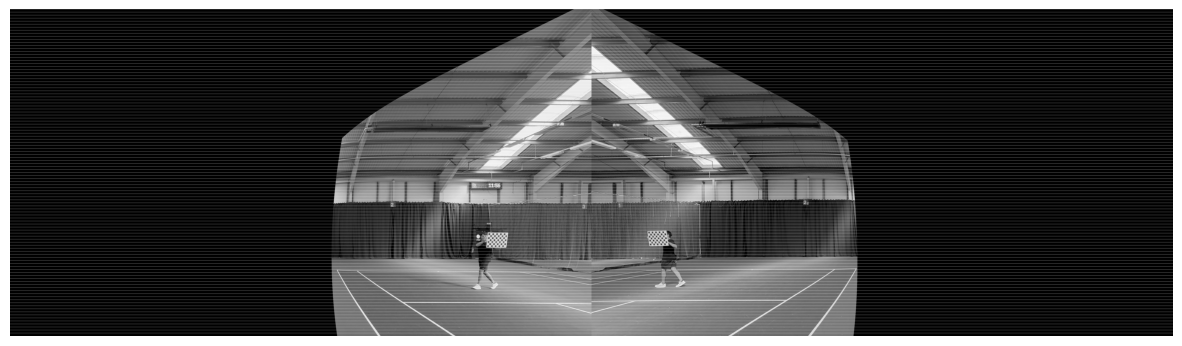

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


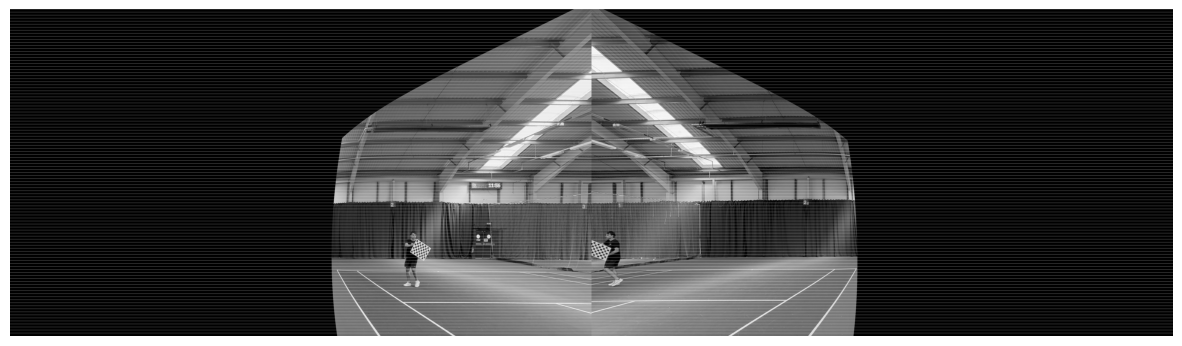

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


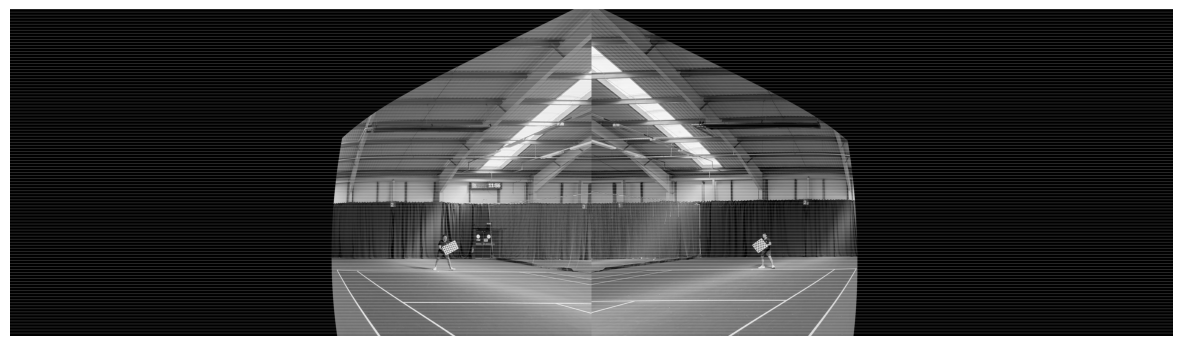

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


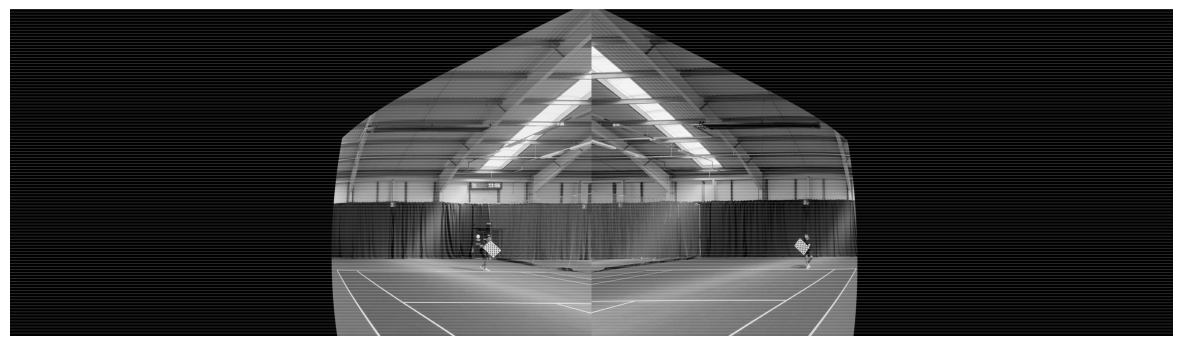

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


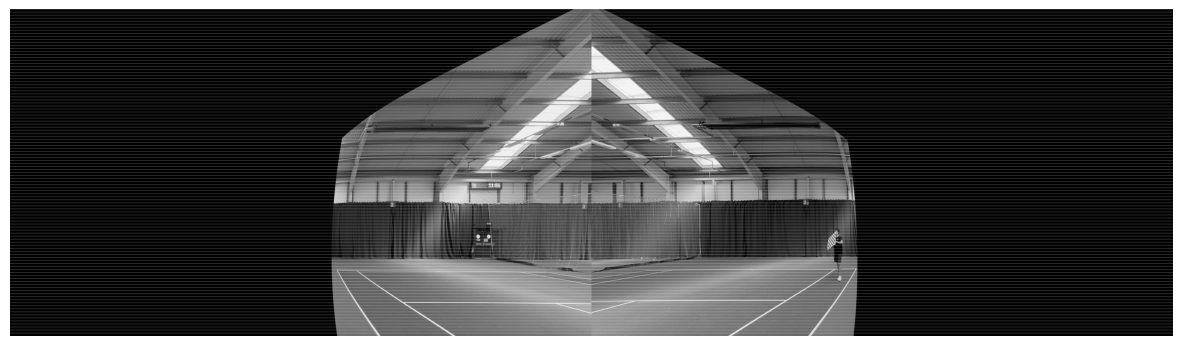

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


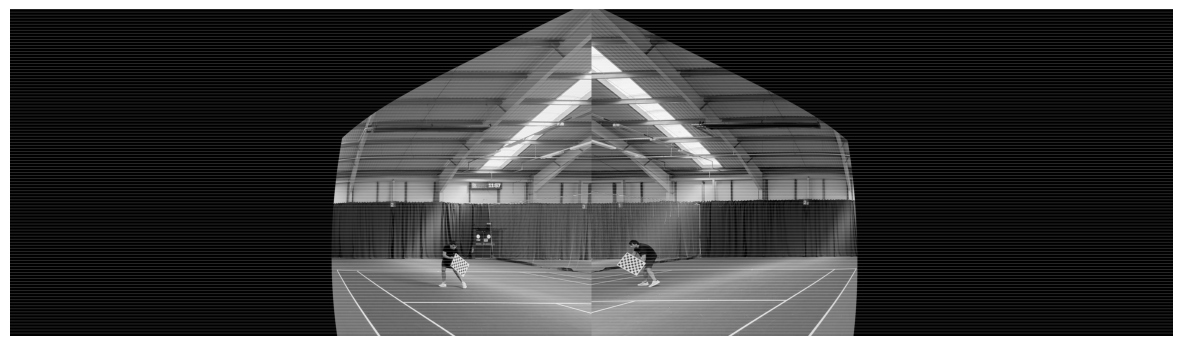

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


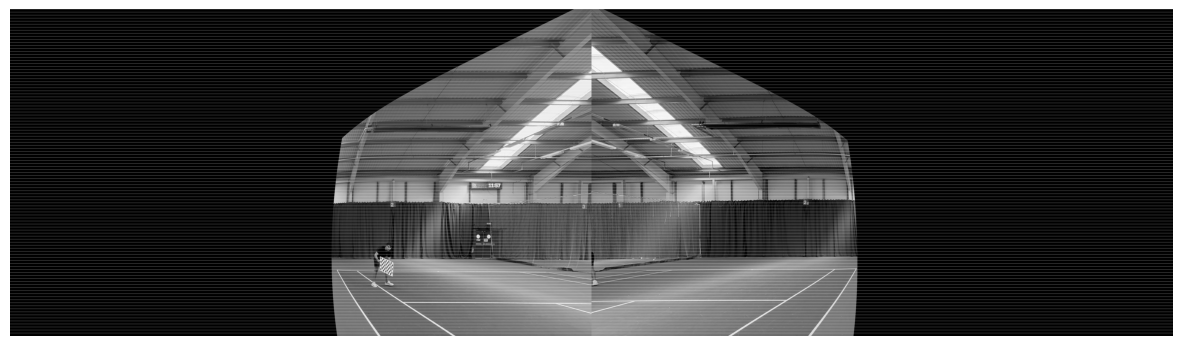

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


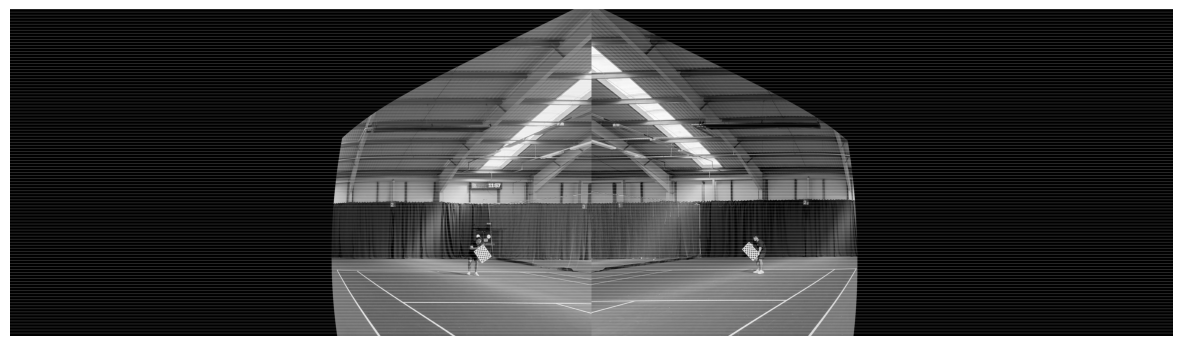

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


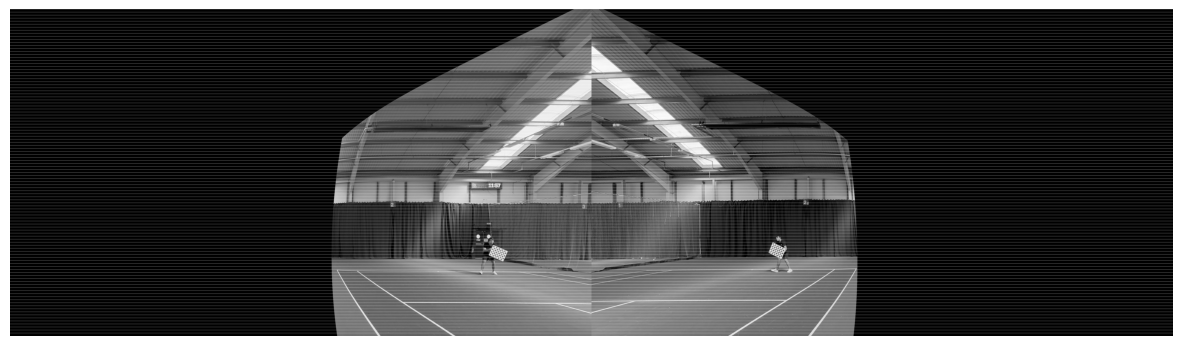

In [20]:
A_stereo_maps = load_stereo_a_maps()
# print(A_stereo_maps["CAM_2_projection_matrix"])
filtered_frames_folder = f"{root}/images/STEREOS/STEREO_A/filtered_stereo_frames"
visualize_rectified_images(filtered_frames_folder, A_stereo_maps["CAM_1_map_x"],
                           A_stereo_maps["CAM_1_map_y"], A_stereo_maps["CAM_2_map_x"], A_stereo_maps["CAM_2_map_y"])

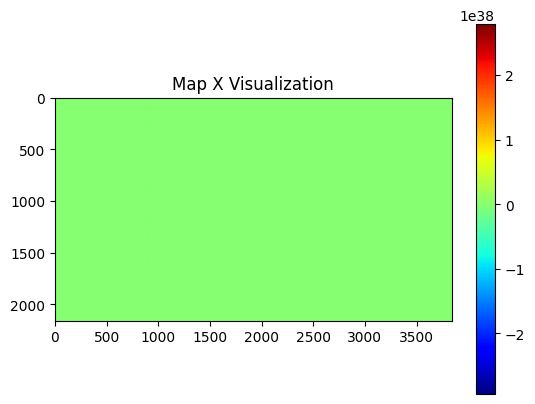

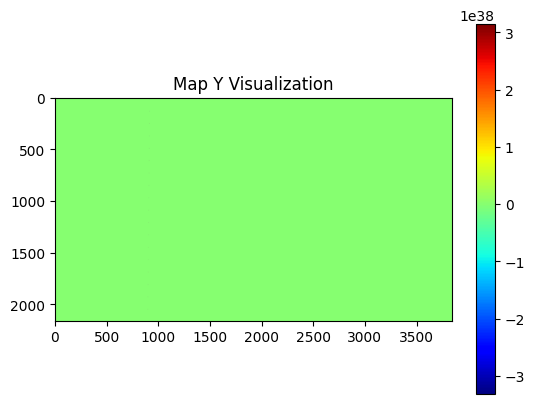

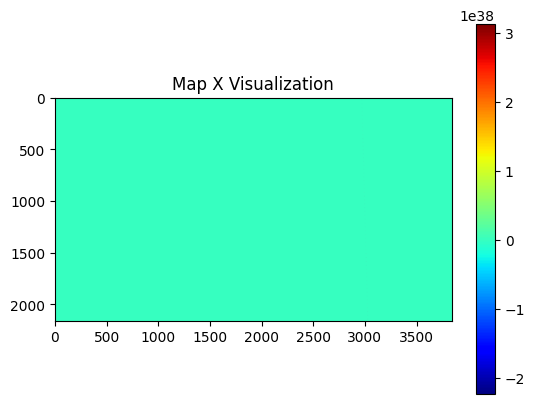

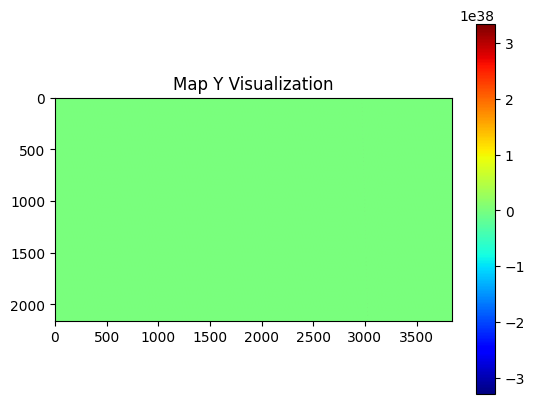

In [24]:
def visualize_stereo_maps(map_x, map_y):
    # Show the mapping for one map (either x or y)
    plt.imshow(map_x, cmap='jet')
    plt.title("Map X Visualization")
    plt.colorbar()
    plt.show()

    # Similarly, visualize the Y map
    plt.imshow(map_y, cmap='jet')
    plt.title("Map Y Visualization")
    plt.colorbar()
    plt.show()


visualize_stereo_maps(A_stereo_maps["CAM_1_map_x"], A_stereo_maps["CAM_1_map_y"])
visualize_stereo_maps(A_stereo_maps["CAM_2_map_x"], A_stereo_maps["CAM_2_map_y"])

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


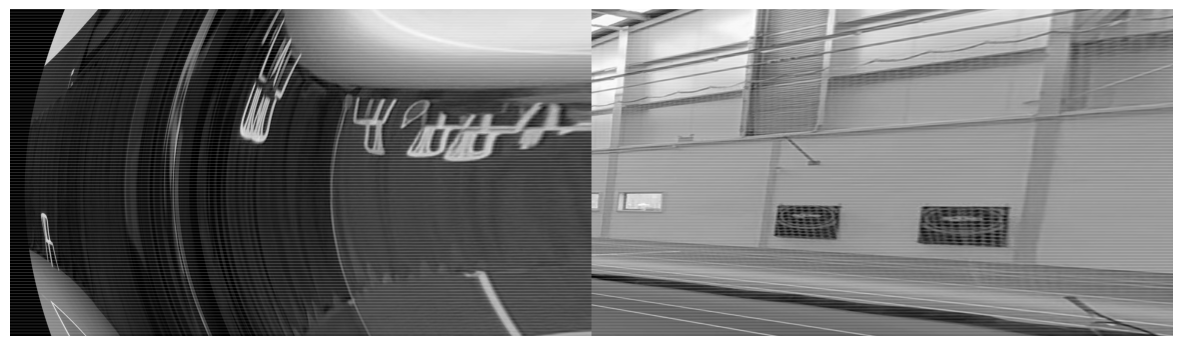

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


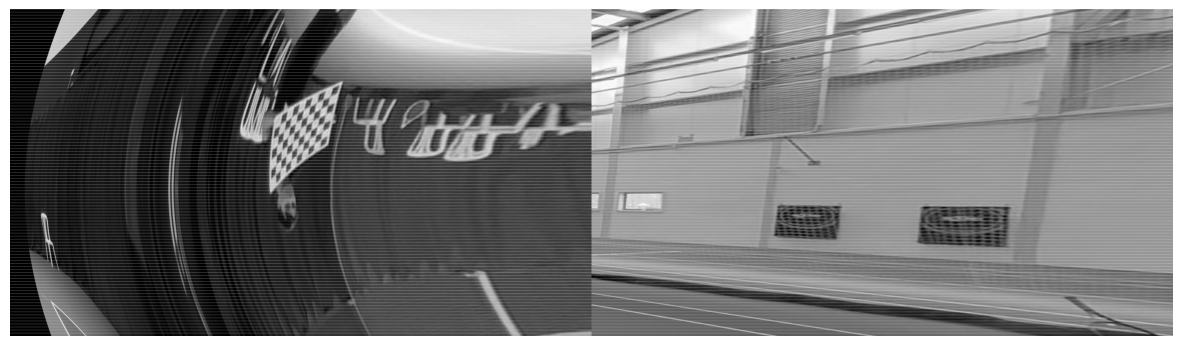

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


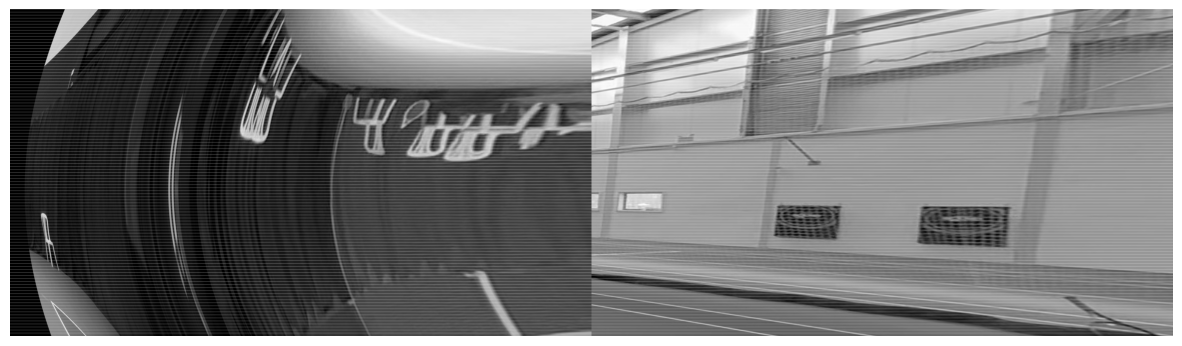

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


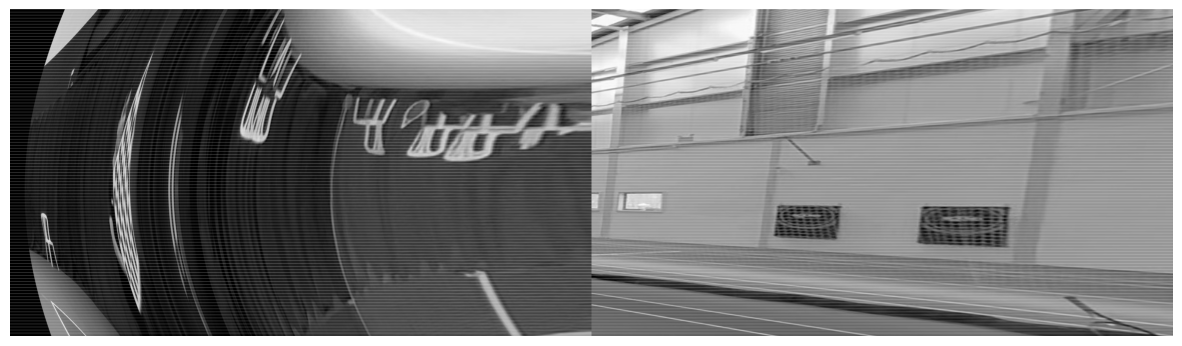

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


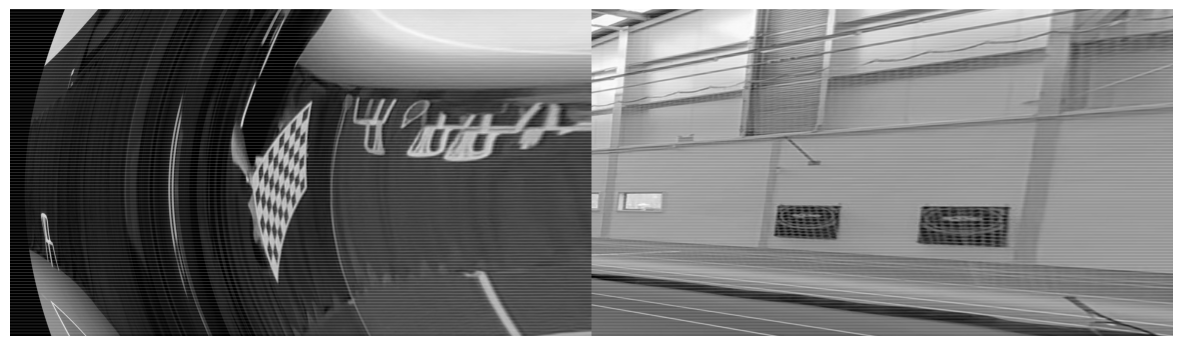

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


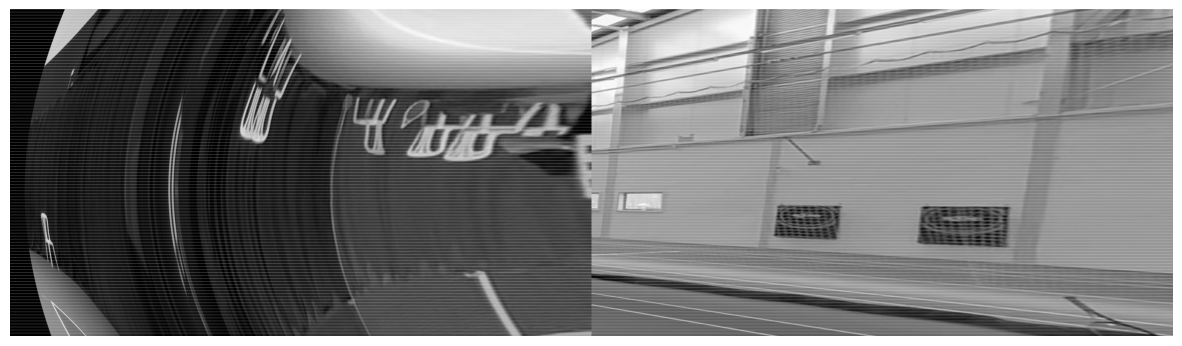

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


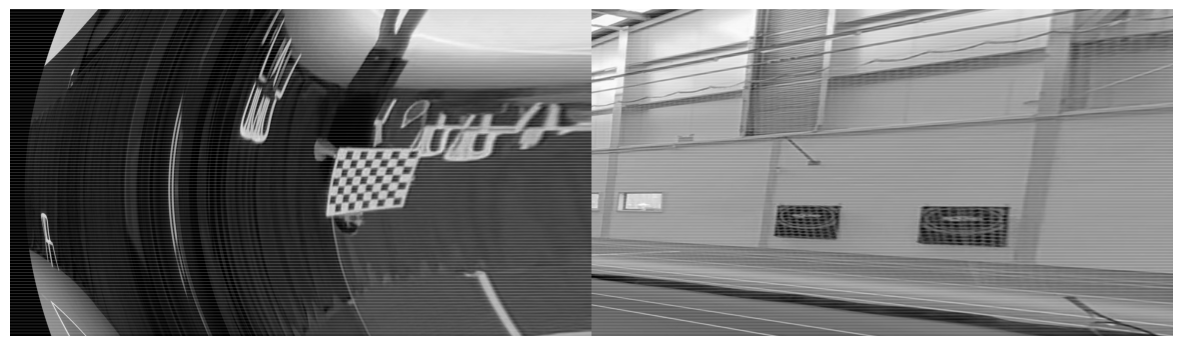

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


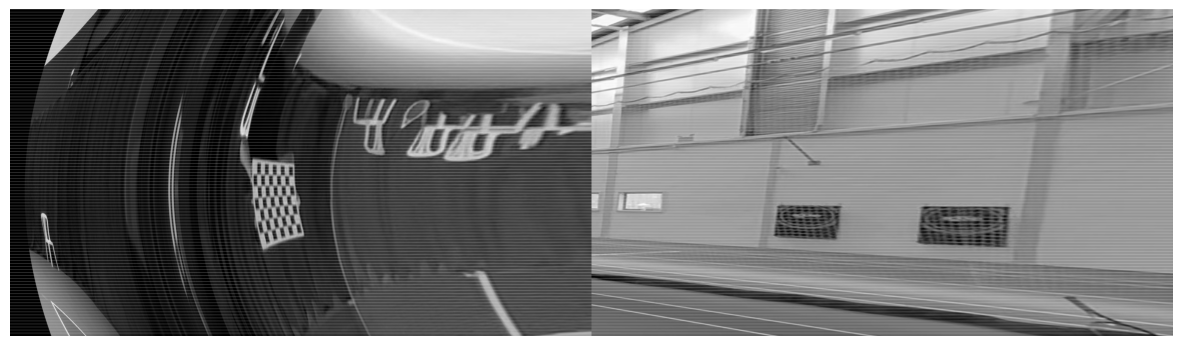

(2160, 3840)
(2160, 3840)
(2160, 3840)
(2160, 3840)


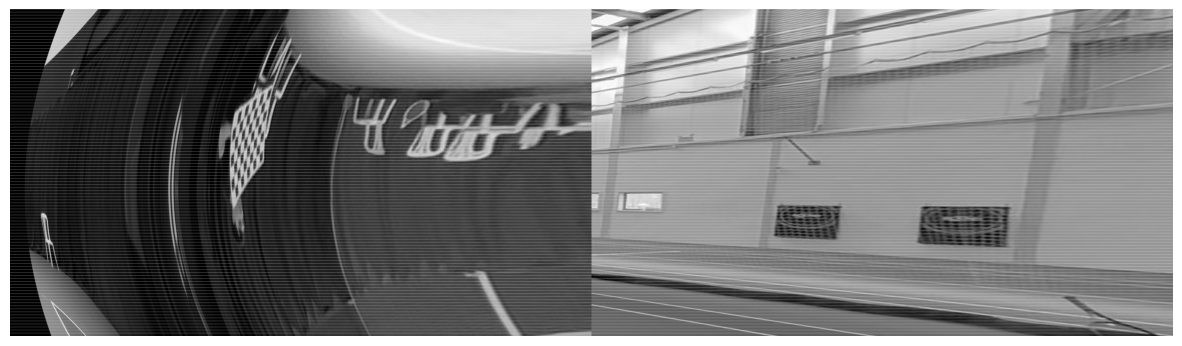

In [34]:
B_stereo_maps = load_stereo_b_maps()
filtered_frames_folder = f"{root}/images/STEREOS/STEREO_B/filtered_stereo_frames"
visualize_rectified_images(filtered_frames_folder, B_stereo_maps["CAM_3_map_x"],
                           B_stereo_maps["CAM_3_map_y"], B_stereo_maps["CAM_4_map_x"], B_stereo_maps["CAM_4_map_y"])

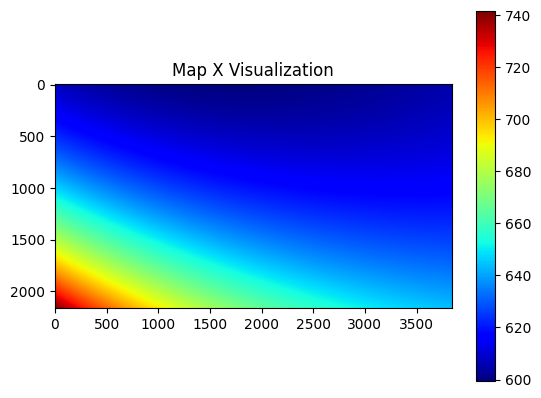

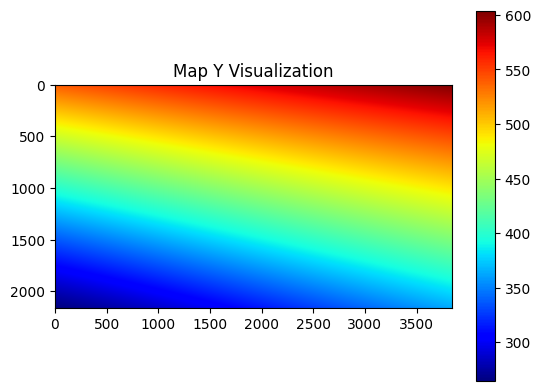

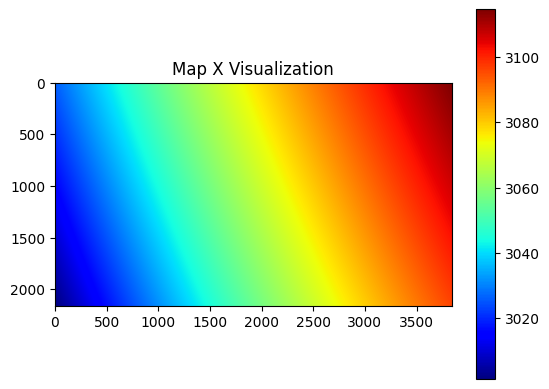

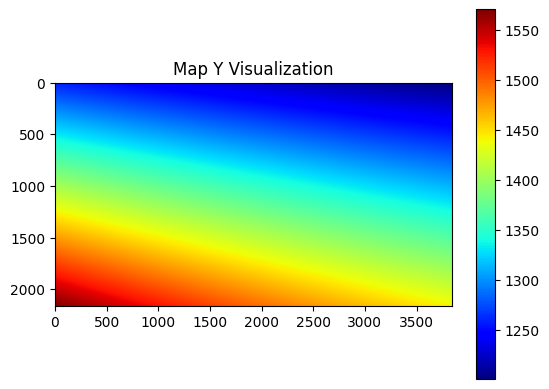

In [27]:
def visualize_stereo_maps(map_x, map_y):
    # Show the mapping for one map (either x or y)
    plt.imshow(map_x, cmap='jet')
    plt.title("Map X Visualization")
    plt.colorbar()
    plt.show()

    # Similarly, visualize the Y map
    plt.imshow(map_y, cmap='jet')
    plt.title("Map Y Visualization")
    plt.colorbar()
    plt.show()

# Visualize stereo maps for CAM_3 and CAM_4
visualize_stereo_maps(B_stereo_maps["CAM_3_map_x"], B_stereo_maps["CAM_3_map_y"])
visualize_stereo_maps(B_stereo_maps["CAM_4_map_x"], B_stereo_maps["CAM_4_map_y"])